## Importing all libraries

In [112]:
#Importing all libraries
import os
import docx2txt

import pandas as pd
import numpy as np
import nltk
import re
import csv
import fasttext
import graphviz
from graphviz import render
from collections import Counter

import multiprocessing
import sklearn.manifold
import gensim.models.word2vec as w2v

In [55]:
# Importing libraries for WordCloud visualization
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Class for converting the whole interview data to dataframe

In [195]:
class InterviewDataPreparation:
    def __init__(self,folderName):
        self.folderName=folderName
        
#Function for converting the data into dataframe
    def to_dataframe(self):
        alist=[]
        rootDir=self.folderName
        arr = os.listdir(rootDir)
        df = pd.DataFrame(columns=['Asked by','Question','Answered by','Answer'])
        i=0
        asker=''
        question=''
        answerer=''
        answer=''
        gotAnswer=False
        
        # Going through each folder in the provided root folder
        for eachFolder in arr:
            folder= rootDir+'/'+eachFolder
            fileList=os.listdir(folder)
            
            #Going through each word files in the folder
            for eachfile in fileList:
                file=folder+'/'+eachfile
                my_text = docx2txt.process(file)
                alist=my_text.split('\n')
                b=list(filter(lambda a: a != '', alist))
                
                for each in b:
                    subcode=''
                    if (re.search('^Interviewer.*:',each.strip())):
                        a=each.split(':')
                        if(len(a)==2):
                            asker=a[0].strip()
                            question=a[1].strip()
                    
                    else:
                        aa=each.split(':')
                        if(len(aa)==2):
                            answerer=aa[0].strip()
                            answer=aa[1].strip()
                            gotAnswer=True
                    
                    if(gotAnswer):           
                        df=df.append({'Asked by': asker, 'Question': question, 'Answered by':answerer,'Answer':answer}, ignore_index=True)    
                        gotAnswer=False
                        
        #Final dataframe have 5 columns ['Asked by', 'Question', 'Answered by', 'Answer']              
        return df                                

In [196]:
Obj=InterviewDataPreparation('D:/FullData')
data=Obj.to_dataframe()

In [197]:
data.columns

Index(['Asked by', 'Question', 'Answered by', 'Answer'], dtype='object')

## Class for preprocessing the data

In [192]:
class DataPreprocess:
    def __init__(self):
        
        #Initializing the stop word list
        self.stop_words = set(nltk.corpus.stopwords.words('english'))
        
        #As the nltk stopwords list is not complete, add more stopwords to it.
        self.stop_words.add('yes')
        self.stop_words.add('yeah')
        self.stop_words.add('would')
        self.stop_words.add('could')
        self.stop_words.add('okay')
        self.stop_words.add('also')
        self.stop_words.add('ok')
        self.stop_words.add('oh')
        self.stop_words.add('th')
        self.stop_words.add('alright')
        self.stop_words.add('without')
        self.stop_words.add('might')
        self.stop_words.add('many')
        self.stop_words.add('much')
        self.stop_words.add('may')
        self.stop_words.add('per')
        self.stop_words.add('otherwise')
        
        #Initializing the lemmatizer
        self.wn=nltk.WordNetLemmatizer()
           
#Function for preprocessing
    def preprocess(self,text):
        #Removing the background information from the data
        text=re.sub("\\(.*?\\)","",text)
        
        #Tokenization
        word_tokens = nltk.word_tokenize(text) 
        
        #POS Tagging
        pos=nltk.pos_tag(word_tokens)
        j=0
        
        #Named Entity Recognition
        for i,k in zip(pos[0:], pos[1:]):
            if ((i[1]=='NNP') & (k[1]=='NNP')):
                word_tokens[j]=i[0]+'-'
            j=j+1   
        text=' '.join(word_tokens)
        text=re.sub('- ','-',text)
        text=re.sub("-","",text)
        
        #Removing non-alphabetic characters
        text = re.sub("[^a-zA-Z]"," ", text)
        word_tokens= nltk.word_tokenize(text)
        filtered_sentence = [] 
        for each in word_tokens:
            if(each.lower() not in self.stop_words):
                filtered_sentence.append(each)         
        text=[]    
        
        #Lemmatization
        for word in filtered_sentence:
            if(word.endswith('ss')==False):
                temp=self.wn.lemmatize(word.lower())
                if(len(temp)>1):
                    text.append(temp)
            else:
                text.append(word.lower())
    
        return text

    #Function for joining tokenized text
    def join(self,text):
        text=' '.join(text)
        return text                     

In [33]:
Obj1=DataPreprocess()
text=Obj1.join(Obj1.preprocess(data['Answer'].loc[2]))
print(text)

sure one corner another corner


In [ ]:
Obj1=DataPreprocess()
text=data['Answer'].apply(Obj1.preprocess).apply(Obj1.join)
print(text)

## Class for Vectorization using Word2Vec

In [106]:
class Vectorization:
    def __init__(self, dataframe, filename, epochs=1, num_features=300, min_word_count=3, context_size=7, downsampling=1e-3):
        
        #Initializing the dataframe
        self.dataframe = dataframe
        
        #Filename to where the vectors to be stored
        self.filename=filename
        
        #more dimensions = more generalized
        self.num_features = num_features
        
        # Minimum word count threshold.
        self.min_word_count = min_word_count

        # Number of threads to run in parallel.
        #more workers, then faster we can train
        self.num_workers = multiprocessing.cpu_count()

        # Context window length.
        self.context_size = context_size

        # Downsample setting for frequent words.
        self.downsampling = downsampling

        # Seed for the RNG, to make the results reproducible.
        self.seed = 1
        
        #Number of epochs to train
        self.epochs=epochs
        self.vectorize()
        
    #Format the column to vectorize into a list after preprocessing it
    def form_the_list(self):
        #Combine the qustion and the answer.
        self.dataframe=self.dataframe.fillna('')
        self.dataframe['Combined']=self.dataframe['Question']+' '+self.dataframe['Answer']
        
        #Preprocess the combined column
        preprocess_obj=DataPreprocess()
        preprocessed_column=self.dataframe['Combined'].apply(preprocess_obj.preprocess)
        self.data_to_vectorize=[]
        for each in preprocessed_column:
            if ((each is not np.nan) and (len(each)>0)):
                self.data_to_vectorize.append(each)
        #return data_to_vectorize
    
    #Function for vectorization
    def vectorize(self):
        self.response2vec = w2v.Word2Vec(
            sg=1,
            seed=self.seed,
            workers=self.num_workers,
            size=self.num_features,
            min_count=self.min_word_count,
            window=self.context_size,
            sample=self.downsampling
          )
        
        #Need to vectorize the contents of 'Combined' column which contains both Question and Answer
        self.form_the_list()
        self.response2vec.build_vocab(self.data_to_vectorize)
        self.response2vec.train(self.data_to_vectorize,total_examples=self.response2vec.corpus_count,epochs=self.epochs)
        
        #Save trained Word2Vec in a specified file.
        #So that we can retrieve and use it whenever we want

        self.response2vec.save(self.filename)
        self.visualize_tsne()
        
    #Function for returning the vectors    
    def get_vectors(self):
        return self.response2vec
        
    #Function for visualizing it using TSNE
    def visualize_tsne(self):
        tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
        all_word_vectors_matrix = self.response2vec.wv.vectors
        
        #Compress multidimensional matrix to 2-D
        all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)
        
        points = pd.DataFrame(
            [
                (word, coords[0], coords[1])
                for word, coords in [
                    (word, all_word_vectors_matrix_2d[self.response2vec.wv.vocab[word].index])
                    for word in self.response2vec.wv.vocab
            ]
        ],
        columns=["word", "x", "y"]
        )
        
        sns.set_context("poster")
        print("TSNE plot of vectors")
        points.plot.scatter("x", "y", s=10, figsize=(20, 12))

C:\Users\mpfou\Anaconda3\lib\site-packages\gensim\models\base_any2vec.py:743: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded, training will be slow. "
C:\Users\mpfou\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


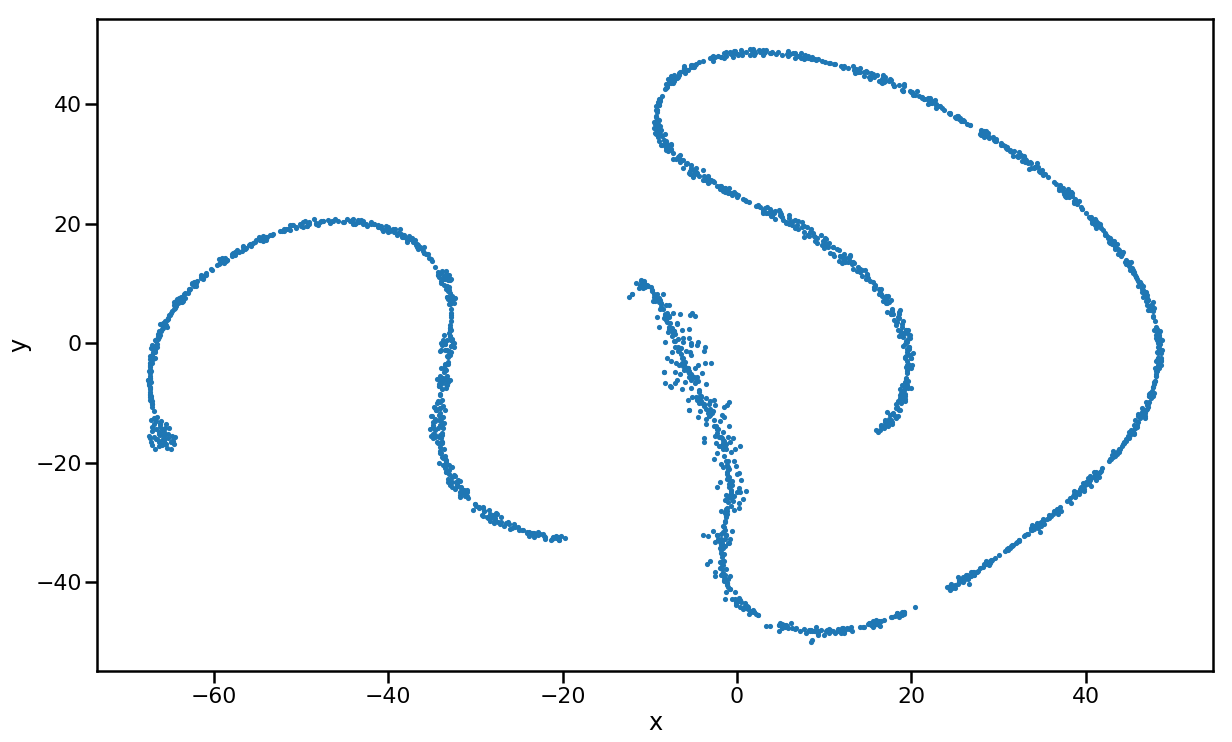

In [100]:
#The output file will be saved with the trained vectors 
Vectorization(data, filename='response2vec300D1.w2v', epochs=1)

#Following is the vectorization obtained with only 1 epoch

## Class for Text Classification using FastText

In [220]:
class ClassifyText:
    def __init__(self, train_data, class_mappings, dataframe, lr=0.01, dim=20, epoch=500,  word_ngrams=2, loss='hs'):
        
        #Training data file name
        self.train_data = train_data
        self.preprocess_train_data = self.train_data_preprocess()
        
        #Class mappings file name
        self.class_mappings=class_mappings
        self.table_class_mappings=self.to_dataframe(self.class_mappings)
        
        #Interview dataframe
        self.dataframe = dataframe
        
        #Learning Rate
        self.lr = lr

        # Dimension
        self.dim = dim

        # Epochs to train
        self.epoch = epoch

        # Word Ngrams
        self.word_ngrams=word_ngrams

        # Loss function at the output layer
        self.loss=loss
        
        self.classified_data, self.codes=self.classify(self.dataframe)
        
    def to_dataframe(self, filename):
        #Initializing an empty dataframe
        df = pd.DataFrame(columns=['Data','Label'])
        
        #Read the training data
        file = open(filename, "r")
        for each in file:
            if(each.startswith('__label__')):
                label=each.partition(' ')[0]
                detail=each.partition(' ')[2].replace('\n','')
                df=df.append({'Data': detail, 'Label': label}, ignore_index=True) 
        return df
    
    #Function for preprocessing the training data
    #The training data is a text file 
    #with each line starting with the label prefixed with "__label__" and then the text corresponding to that label
    def train_data_preprocess(self):
         
        train_df= self.to_dataframe(self.train_data)
        #Getting the list of classes from the data
        self.classes=train_df['Label'].unique()
        
        #Preprocess the training data
        preprocess_obj=DataPreprocess()
        train_df['Data_clean']=train_df['Data'].apply(preprocess_obj.preprocess).apply(preprocess_obj.join) 
        
        #Shuffle the data
        FinalDf=train_df.sample(n=train_df.shape[0])
        preprocess_train_data_file='preprocess_train.txt'
        
        #Save the preprocessed train data into a file 'preprocess_train.txt'
        FinalDf[['Label','Data_clean']].to_csv(preprocess_train_data_file, header=None, index=None, sep=' ', mode='a',quoting=csv.QUOTE_NONE, escapechar=' ')
        return preprocess_train_data_file
    
    #Function for getting the classes from the provided training data
    def get_classes(self):
        return self.classes
    
    #Function for text classification
    def classify(self,data):
        #Train the data with FastText
        model = fasttext.train_supervised(self.preprocess_train_data, lr=self.lr, dim=self.dim, epoch=self.epoch,  word_ngrams=self.word_ngrams, loss=self.loss)
        
        #Preprocess the combined column
        preprocess_obj=DataPreprocess()
        data=data.fillna('')
        data['Combined']=data['Question']+' '+data['Answer']
        data['Data_clean']=data['Combined'].apply(preprocess_obj.preprocess).apply(preprocess_obj.join)
        
        #Taking only the records in which there is atleast 3 words after preprocessing
        testdata=data[data['Data_clean'].map(lambda d: len(d.split(' '))) > 2][['Question','Answer','Data_clean']]
        
        #Predict the label
        labels = model.predict(testdata['Data_clean'].tolist(),k=1)
        codes=[]
        for each in labels[0]:
            codes.append(each[0])
            
        #Assigning the predicted labels for the respective rows
        testdata['Labels']=codes
        
        #Assiging the similarity value of each predicted labels
        testdata['Probs']=labels[1]
        
        codes=dict()
        print("WordCloud Visualization from FastText\n")
        self.table_class_mappings.set_index('Label',inplace=True)
        for each in self.classes:
            each_df=testdata[testdata['Labels']==each]
            print(self.table_class_mappings.loc[each]['Data'])
            # Getting keywords of each labels
            text = " ".join(review for review in each_df['Data_clean'])
            try:
                # Create and generate a word cloud image:
                wordcloud = WordCloud(background_color="white").generate(text)
                keywords=Counter(text.split())
                codes[each]=[i for i in keywords if keywords[i] > 10]
            
                # Display the generated image:
                plt.imshow(wordcloud, interpolation='bilinear')
                plt.axis("off")
                plt.show()
            except:
                pass
        return testdata,codes
    
    def get_keywords(self):
        return self.codes,self.table_class_mappings
    def get_classified_data(self):
        return self.classified_data

               Data          Label
0  Tools And Design  __label__tool
1  Chronic Diseases    __label__cd
2           Poverty   __label__pov
3    Communications  __label__comm
4   Self Management    __label__sm
5    Social Support    __label__ss
6    Job and Income   __label__job
WordCloud Visualization from FastText

Self Management


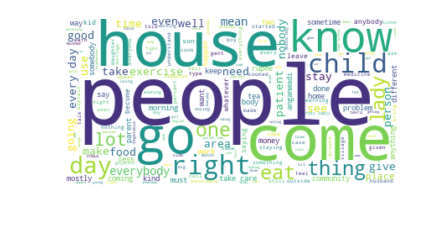

Social Support


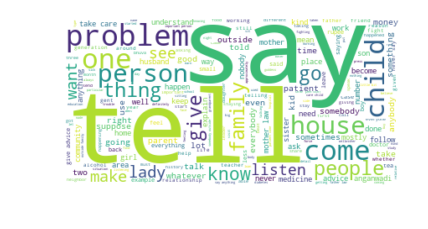

Chronic Diseases


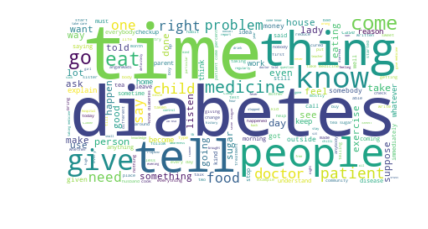

Job and Income


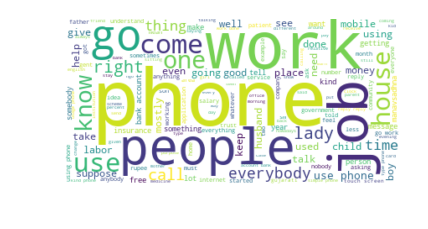

Communications


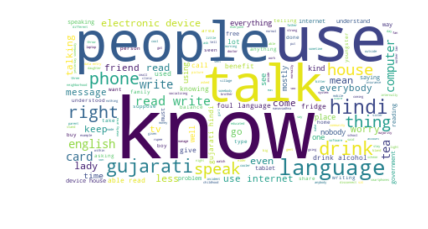

Tools And Design


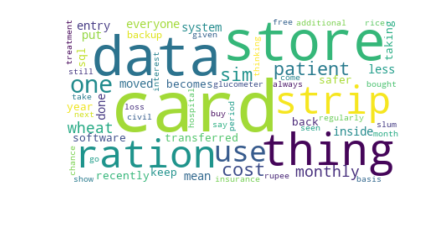

Poverty


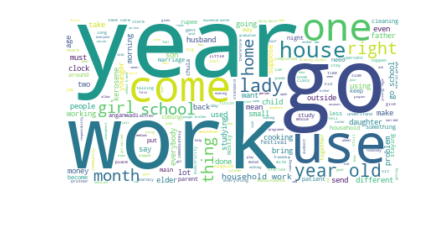

In [182]:
#Text classification alone
classes=ClassifyText(train_data='dataForFasttext.txt',class_mappings='class_mappings.txt', data=data)

In [117]:
codes=classes.get_keywords()

## Class for FastText and Word2Vec

In [235]:
#We need the codes from the FastText, and it need to be given as input to Word2Vec to get the subcodes
#If pre_trained=False, then the newly created vectors will be saved in the specified file.
#If pre_trained=True, then the trained vectors will be retrieved from the specified file.
class TextualGraph:
    def __init__(self, train_data, class_mappings, data, filename, pre_trained=False, vector_dim=300, vector_epoch=1, min_word_count=3, context_size=7, downsampling=1e-3,
                 fast_text_epoch=500, fast_text_lr=0.01, fast_text_ngrams=2, fast_text_loss='hs' ):
        
        self.vector_dim=vector_dim
        self.vector_epoch=vector_epoch
        self.min_word_count=min_word_count
        self.context_size=context_size
        self.downsampling=downsampling
        self.fast_text_epoch=fast_text_epoch
        self.fast_text_lr=fast_text_lr
        self.fast_text_ngrams=fast_text_ngrams
        self.fast_text_loss=fast_text_loss
        
        self.train_data=train_data
        self.class_mappings=class_mappings
        self.data=pd.read_csv(data, encoding='utf-8')
        self.pre_trained=pre_trained
        self.filename=filename
        
        self.start_model()
        
    #Function for getting the vectors and codes
    def start_model(self):      
        
        #Classify the provided data
        classify=ClassifyText(train_data=self.train_data, class_mappings=self.class_mappings, dataframe=self.data, lr=self.fast_text_lr, dim=self.vector_dim, 
                              epoch=self.fast_text_epoch, word_ngrams=self.fast_text_ngrams, loss=self.fast_text_loss)
        self.codes, self.table_class_mappings=classify.get_keywords()
        self.classified_data=classify.get_classified_data()
        
        #Preprocess the answer columns
        preprocess_obj=DataPreprocess()
        self.classified_data['Answer_clean']=self.classified_data['Answer'].apply(preprocess_obj.preprocess).apply(preprocess_obj.join)
        
        #Do or get vectors
        if(self.pre_trained):
            #Function for loading the saved vector model
            self.response2vec = w2v.Word2Vec.load(self.filename)
        else:
            vect=Vectorization(self.data, filename=self.filename, epochs=self.vector_epoch, num_features=self.vector_dim, 
                               min_word_count=self.min_word_count, context_size=self.context_size, downsampling=self.downsampling)
            self.response2vec=vect.get_vectors()
        self.visualize_graph()
        
    #Function for cleaning the branch to remove duplicate elements
    def clean_branch(self, keyword, branch):
        for b in branch:
            aa=' '
            if(b[0].endswith('ing') | b[0].endswith('ed') | b[0].endswith('ry') | b[0].endswith('s')):
                if(b[0].endswith('ing')):
                    aa=b[0][:-3]
                else:
                    aa=b[0][:-2]
            for i in branch:
                if(((i[0].startswith(aa)) & (i[0]!=b[0]))):
                    branch.remove(i)
        
                #Removing the duplicate codes from codes and subcodes
                if((keyword.startswith(aa)) | (b[0].startswith(keyword)) | (keyword.startswith(b[0])) | (b[0].endswith('ben'))): 
                    if(b in branch):
                        branch.remove(b)
        return branch


    #Fucntion to clean the edges formed when there is duplication
    def clean_edges(self, edges):
        for each in edges:
        #Split each element to check whether the list contain the same element in swapped form 
            splitted=each.split(' ')
            if(len(splitted)>1):
                swap=splitted[1]+' '+splitted[0]
                if(swap in edges):
                    edges.remove(swap)         
        return edges 


    #Function for plotting the codes and subcodes  
    def plot_graph(self, code, df, keyword):
        edges=[]
        #Initializing the graph
        code_graph = graphviz.Digraph(strict=True)
        root=code
  
        #Creating the root and next level node with the code
        code_graph.node(root,color='red')
        code_graph.node(keyword,color='blue')
  
        #Obtaining the branch from the root node
        branch=self.response2vec.most_similar(keyword)
        branch=self.clean_branch(keyword,branch)
  
        #Finding the codes in the branch are related with the respective category
        for b in branch: 
            subcodes=[]
            subcodes1=[]
            temp=self.classified_data[(self.classified_data['Data_clean'].str.contains(keyword)) & (self.classified_data['Data_clean'].str.contains(b[0]))]  
            details=[]
            for ans in temp['Answer']:
                details.append(ans)
            if(len(details)>0):  
                code_graph.edge(root,keyword)
                branch1=self.response2vec.most_similar(b[0])
      
      
                #Drilling down to find subcodes from codes
                for b1 in branch1:
                    temp1=self.classified_data[(self.classified_data['Answer_clean'].str.contains(b[0]+' '+b1[0])) | (df['Answer_clean'].str.contains(b1[0]+' '+b[0]))]  
                    details1=[]
                    for ans in temp1['Answer']:
                        details1.append(ans)
          
        
                    #Checking whether the codes and subcodes are present in the respective category
                    if(len(details1)>0):
                        for b11 in branch1:
                            temp2=self.classified_data[(self.classified_data['Answer_clean'].str.contains(b[0]+' '+b1[0]+' '+b11[0]))]
                            details2=[]
                            for ans in temp2['Answer']:
                                details2.append(ans)
                            if(len(details2)>0):
                                subcodes.append(b[0]+' '+b1[0]+' '+b11[0])
                                extra=b[0]+' '+b1[0]
                                subcodes=list(filter(lambda a: a != extra, subcodes))
                                break
                            else:
                                if(b[1]>0.55):
                                    subcodes.append(b[0]+' '+b1[0])
                        break
                    else:
                        if((b[0] not in subcodes1) & (b[1]>0.55)):
                            subcodes1.append(b[0])
            
      
                #Creating an edge from codes to subcodes in the graph.
                if(len(subcodes)>0):
                    edges.append(subcodes[0])
                elif(len(subcodes1)>0):
                    edges.append(subcodes1[0])
        
        #Cleaning the edge      
        clean_edge=self.clean_edges(edges)  
        for each in clean_edge:
            code_graph.edge(keyword,each)
    
        #Render the graph 
        if(len(clean_edge)>0):
            code_graph.render(os.path.join('VisualGraphs/'+code, keyword+'.gv'), format='png',view=True)
    
    def visualize_graph(self):
        for each in self.codes:
            key_code=self.table_class_mappings.loc[each]['Data']
            try:
                os.makedirs(os.path.join('VisualGraphs', key_code))
            except:
                print('Folder already exist')
            each_df=self.classified_data[self.classified_data['Labels']==each]
            for subkey in self.codes[each]:
                self.plot_graph(key_code, each_df, subkey)
        print("Visual Graphs are done!!!")

WordCloud Visualization from FastText

Self Management


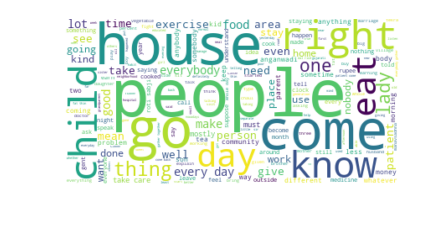

Social Support


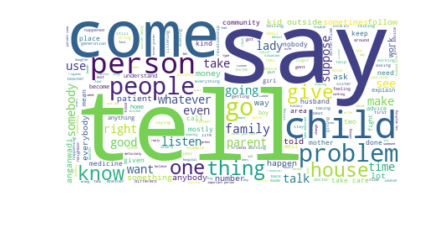

Chronic Diseases


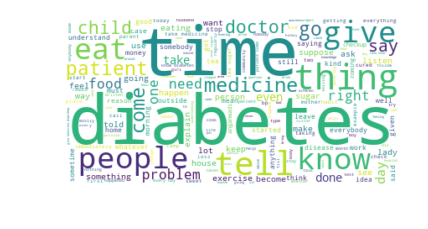

Job and Income


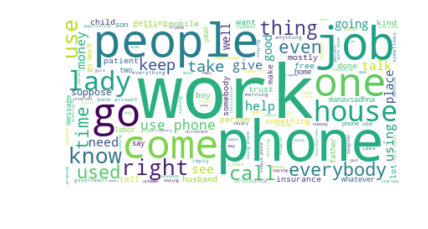

Communications


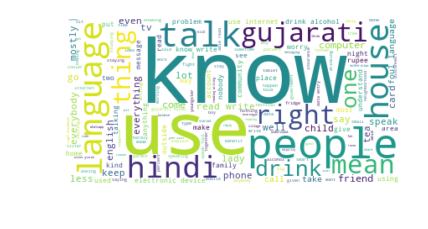

Tools And Design


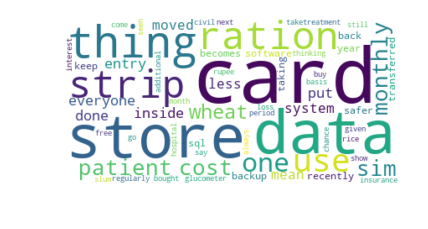

Poverty


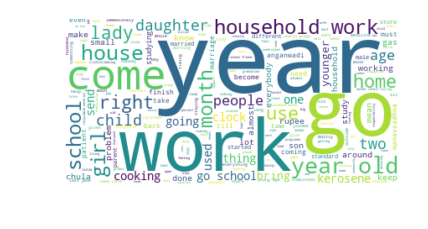

Visual Graphs are done!!!


C:\Users\mpfou\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [236]:
#We will get a folder 'VisualGraphs' with the graph visualizations from the respective categories
#Combination of FastText and Word2Vec
TextualGraph(train_data='train_data.txt',class_mappings='class_mappings.txt', data='CleanData.csv',filename='response2vec300D20.w2v',pre_trained=True)